# Assignment 1 — Loan Default Prediction using KNN



In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn-v0_8-whitegrid')

In [11]:
df = pd.read_csv('https://raw.githubusercontent.com/bijayam/GenAI-Application-Developer-Assignment-L3/refs/heads/main/loan_default_dataset.csv')
df

,Age,Annual Income (lakhs),Credit Score,Loan Amount (lakhs),Loan Term (years),Employment Type,loan
0,28,6.5,720,5,5,Salaried,0
1,45,12.0,680,10,10,Self-Employed,1
2,35,8.0,750,6,7,Salaried,0
3,50,15.0,640,12,15,Self-Employed,1
4,30,7.0,710,5,5,Salaried,0
5,42,10.0,660,9,10,Salaried,1
6,26,5.5,730,4,4,Salaried,0
7,48,14.0,650,11,12,Self-Employed,1
8,38,9.0,700,7,8,Salaried,0
9,55,16.0,620,13,15,Self-Employed,1


In [12]:
print('Shape:', df.shape)
print('Class distribution (loan):', df['loan'].value_counts())
print('Numeric summary:')
print(df[['Age','Annual Income (lakhs)','Credit Score','Loan Amount (lakhs)','Loan Term (years)']].describe())

Shape: (10, 7)
Class distribution (loan): loan
0    5
1    5
Name: count, dtype: int64
Numeric summary:
             Age  Annual Income (lakhs)  Credit Score  Loan Amount (lakhs)  \
count  10.000000              10.000000     10.000000            10.000000   
mean   39.700000              10.300000    686.000000             8.200000   
std     9.922477               3.750556     42.739521             3.224903   
min    26.000000               5.500000    620.000000             4.000000   
25%    31.250000               7.250000    652.500000             5.250000   
50%    40.000000               9.500000    690.000000             8.000000   
75%    47.250000              13.500000    717.500000            10.750000   
max    55.000000              16.000000    750.000000            13.000000   

       Loan Term (years)  
count          10.000000  
mean            9.100000  
std             4.012481  
min             4.000000  
25%             5.500000  
50%             9.000000  
75% 

In [13]:
X = df.drop(columns=['loan'])
y = df['loan']

numeric_features = ['Age','Annual Income (lakhs)','Credit Score','Loan Amount (lakhs)','Loan Term (years)']
categorical_features = ['Employment Type']

preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

knn = KNeighborsClassifier()
pipe_knn = Pipeline([('prep', preprocess), ('model', knn)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {
    'model__n_neighbors': [1,3,5],
    'model__weights': ['uniform','distance'],
    'model__p': [1,2]
}
search = GridSearchCV(pipe_knn, param_grid, cv=cv, scoring='accuracy')
search.fit(X, y)
print('Best params:', search.best_params_)
print('Best CV accuracy:', search.best_score_)

best_knn = search.best_estimator_
pred = cross_val_predict(best_knn, X, y, cv=cv)
print('Classification report (CV):', classification_report(y, pred))
print('Confusion matrix (CV):', confusion_matrix(y, pred))

Best params: {'model__n_neighbors': 3, 'model__p': 2, 'model__weights': 'uniform'}
Best CV accuracy: 1.0
Classification report (CV):               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Confusion matrix (CV): [[5 0]
 [0 5]]


In [14]:
best_knn.fit(X, y)
proba = best_knn.predict_proba(X)[:,1]
risk_df = df.copy()
risk_df['pred_default_proba'] = proba
risk_df.sort_values('pred_default_proba', ascending=False)

,Age,Annual Income (lakhs),Credit Score,Loan Amount (lakhs),Loan Term (years),Employment Type,loan,pred_default_proba
1,45,12.0,680,10,10,Self-Employed,1,1.000000
3,50,15.0,640,12,15,Self-Employed,1,1.000000
9,55,16.0,620,13,15,Self-Employed,1,1.000000
7,48,14.0,650,11,12,Self-Employed,1,1.000000
5,42,10.0,660,9,10,Salaried,1,0.666667
8,38,9.0,700,7,8,Salaried,0,0.333333
0,28,6.5,720,5,5,Salaried,0,0.000000
2,35,8.0,750,6,7,Salaried,0,0.000000
4,30,7.0,710,5,5,Salaried,0,0.000000
6,26,5.5,730,4,4,Salaried,0,0.000000


In [15]:
r = permutation_importance(best_knn, X, y, n_repeats=30, random_state=42, scoring='accuracy')
feature_names = X.columns.tolist()
# The original line below incorrectly added one-hot encoded feature names directly, leading to a length mismatch.
# ohe = best_knn.named_steps['prep'].named_transformers_['cat']
# feature_names += list(ohe.get_feature_names_out(['Employment Type']))
importances = (pd.DataFrame({'feature': feature_names,
                             'importance_mean': r.importances_mean,
                             'importance_std': r.importances_std})
               .sort_values('importance_mean', ascending=False))
importances

,feature,importance_mean,importance_std
2,Credit Score,0.036667,0.060461
3,Loan Amount (lakhs),0.033333,0.053748
1,Annual Income (lakhs),0.026667,0.044222
0,Age,0.026667,0.051208
4,Loan Term (years),0.020000,0.040000
5,Employment Type,0.000000,0.000000


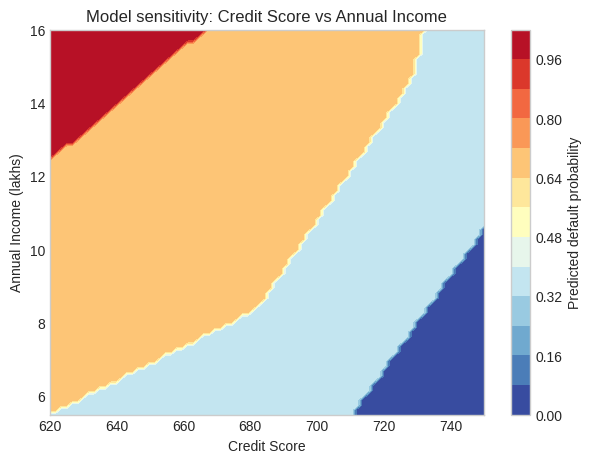

In [16]:
# Credit Score vs Income decision surface
import numpy as np
fixed = {
    'Age': df['Age'].median(),
    'Loan Amount (lakhs)': df['Loan Amount (lakhs)'].median(),
    'Loan Term (years)': df['Loan Term (years)'].median(),
    'Employment Type': 'Salaried'
}
cs_grid = np.linspace(df['Credit Score'].min(), df['Credit Score'].max(), 80)
inc_grid = np.linspace(df['Annual Income (lakhs)'].min(), df['Annual Income (lakhs)'].max(), 80)
CS, INC = np.meshgrid(cs_grid, inc_grid)
rows = []
for i in range(CS.shape[0]):
    for j in range(CS.shape[1]):
        rows.append({'Age': fixed['Age'],
                     'Annual Income (lakhs)': INC[i,j],
                     'Credit Score': CS[i,j],
                     'Loan Amount (lakhs)': fixed['Loan Amount (lakhs)'],
                     'Loan Term (years)': fixed['Loan Term (years)'],
                     'Employment Type': fixed['Employment Type']})
Xg = pd.DataFrame(rows)
Z = best_knn.predict_proba(Xg)[:,1].reshape(CS.shape)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
cp = plt.contourf(CS, INC, Z, levels=15, cmap='RdYlBu_r')
plt.colorbar(cp, label='Predicted default probability')
plt.xlabel('Credit Score')
plt.ylabel('Annual Income (lakhs)')
plt.title('Model sensitivity: Credit Score vs Annual Income')
plt.show()

In [17]:
from sklearn.metrics import pairwise_distances
Xt = best_knn.named_steps['prep'].transform(X)
raw_num = X[['Age','Annual Income (lakhs)','Credit Score','Loan Amount (lakhs)','Loan Term (years)']].values
scaled_dist = pairwise_distances(Xt, Xt).mean()
raw_dist = pairwise_distances(raw_num, raw_num).mean()
print('Mean pairwise distance (scaled):', scaled_dist)
print('Mean pairwise distance (raw numeric):', raw_dist)

from sklearn.preprocessing import StandardScaler
num_scaled = StandardScaler().fit_transform(raw_num)
amp = num_scaled.copy()
loan_idx = 3
amp[:, loan_idx] *= 50
print('Mean pairwise distance (properly scaled):', pairwise_distances(num_scaled).mean())
print('Mean pairwise distance (loan amount x50):', pairwise_distances(amp).mean())

Mean pairwise distance (scaled): 2.7431539273453014
Mean pairwise distance (raw numeric): 48.431765630866764
Mean pairwise distance (properly scaled): 2.6045908993039184
Mean pairwise distance (loan amount x50): 56.92994672063717


In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dt = DecisionTreeClassifier(random_state=42, max_depth=3)
pipe_dt = Pipeline([('prep', preprocess), ('model', dt)])
acc_knn = cross_val_score(best_knn, X, y, cv=5, scoring='accuracy').mean()
acc_dt = cross_val_score(pipe_dt, X, y, cv=5, scoring='accuracy').mean()
print(f'KNN CV accuracy: {acc_knn:.3f}')
print(f'Decision Tree CV accuracy: {acc_dt:.3f}')

KNN CV accuracy: 1.000
Decision Tree CV accuracy: 0.900
